## Travelling Salesman Problem 

In [71]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp

from qiskit_algorithms.optimizers import SPSA

from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [72]:


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


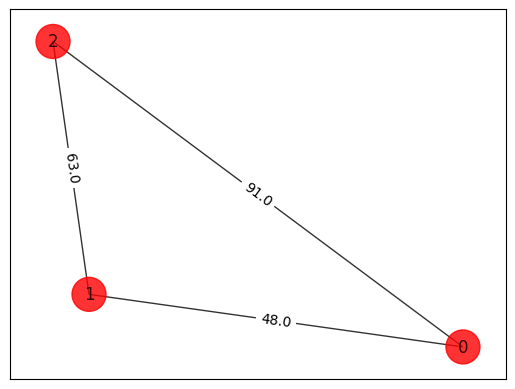

In [73]:
# Generating a graph of 3 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

## Brute Force Approach

order = (0, 1, 2) Distance = 202.0
Best order from brute force = (0, 1, 2) with total distance = 202.0


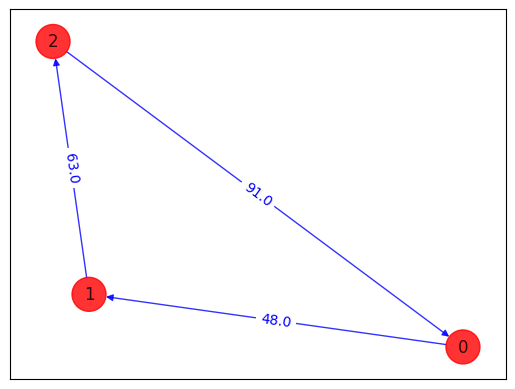

In [74]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

## Mapping it to an Ising Problem

In [75]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [76]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 7581.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-1282.5 +0.j, -1282.5 +0.j, -1282.5 +0.j, -1268.5 +0.j, -1268.5 +0.j,
 -1268.5 +0.j, -1290.  +0.j, -1290.  +0.j, -1290.  +0.j,   606.5 +0.j,
   606.5 +0.j,   606.5 +0.j,    12.  +0.j,    12.  +0.j,   606.5 +0.j,
    22.75+0.j,    22.75+0.j,   606.5 +0.j,    12.  +0.j,   606.5 +0.j,
    12.  +0.j,    22.75+0.j,   606.5 +0.j,    22.75+0.j,    

## Running on actual Quantum Device

In [78]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Options, Session

In [7]:


# loading the IBM Acoount with the Backend
QiskitRuntimeService.save_account(channel="ibm_quantum", token="<Enter Your Token Here>",overwrite=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)



The Backend is:  ibmq_mumbai


In [79]:
print("The Backend is: ",backend.name)

The Backend is:  ibmq_mumbai


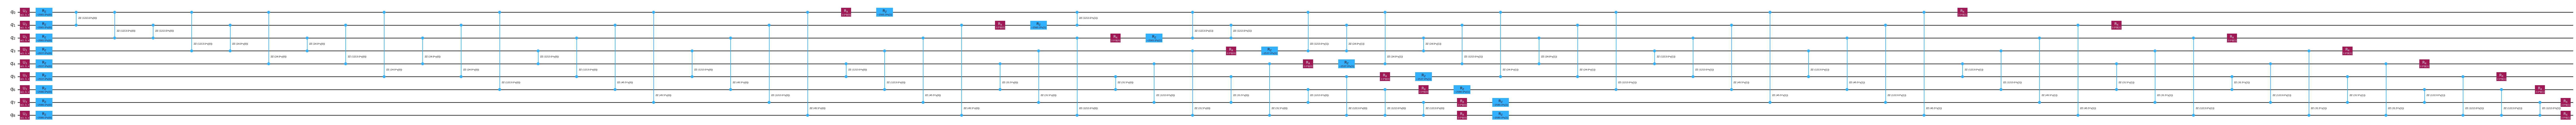

In [80]:
from qiskit.circuit.library import QAOAAnsatz
hamiltonian = qubitOp
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp",fold=-1)

In [81]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

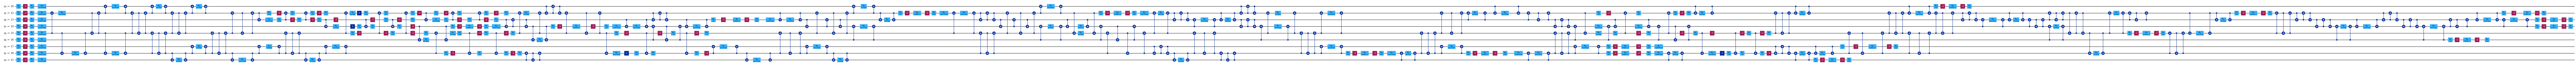

In [82]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp",fold=-1)

In [83]:
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIZIIIZIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIZIIIIIIIIII', 'IIIIIZIIZIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIZIIIIIIIIIIIIIII', 'IIIIIZIIIIZIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIZIIIIIIIIIIII', 'IIIIIZIIIIIIZIIIIIIIIIIIIII', 'IIIIIZIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIZIIIIIIIIII', 'IIIIIIIIZZIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIZIIIIIIIIIIIIIII', 'IIIIIIIIIZZIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIZIIIIIIIIIIII', 'IIIIIIIIIZIIZIIIIIIIIIIIIII', 'IIIIIIIIIZIIIZIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIZIIIIZIIIIIIIIII', 'IIIIIIIIIIZIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIZIZIIIIIIIIII', 'IIIIIIIIIIIIZIIIZIIIIIIIIII', 'IIIIIIIIIIIIIZIIZIIIIIIIIII', 'IIIIIIIIZIIZIIIIIIIIIIIIIII', 'IIIIIIIIZIZIIIIIIIIIIII

In [84]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

In [85]:
# To run on local simulator:
#   1. Use the StatevectorEstimator from qiskit.primitives instead.
#   2. Remove the Session instantiation below.
session = Session(backend=backend)

# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 100


# Configure sampler
sampler = Sampler(session=session)
sampler.options.default_shots = 100


In [86]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

In [87]:
from scipy.optimize import minimize
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

In [88]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -539.3151267136154
       x: [ 4.263e+00  3.250e+00  3.964e-01  4.333e+00]
    nfev: 51
   maxcv: 0.0

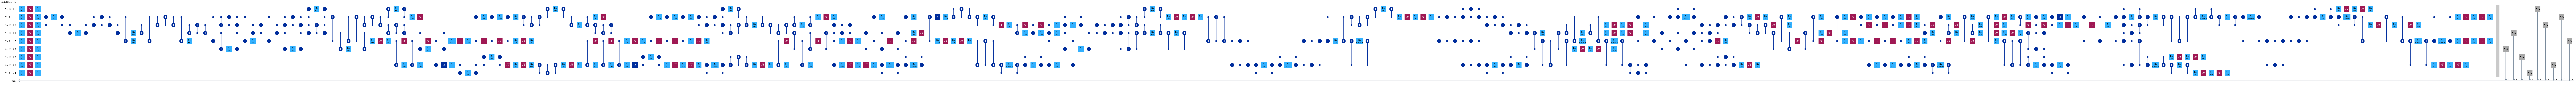

In [91]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="iqp",fold=-1)

In [92]:
result = sampler.run([qc_isa]).result()

In [93]:
print(result)

SamplerResult(quasi_dists=[{0: 0.002691043661388, 1: 0.002212245439844, 2: -0.00039949664488, 3: 0.00123038719238, 4: 0.001368030663539, 5: 0.00269300521815, 6: 0.00225631554102, 7: 0.000276452598077, 8: 0.001606879749123, 9: 0.002607066999094, 10: 0.002310617741817, 11: 0.000138861423639, 12: 0.001506413245159, 13: 0.003422843418166, 14: 0.003555262982416, 15: 0.002664561735484, 16: 0.003427729391508, 17: 0.002105082130761, 18: 0.001125732229953, 19: 0.00123536838588, 20: 0.002195568388926, 21: 0.002694613103497, 22: 0.001868463877441, 23: 0.001471467884622, 24: 0.001901920548638, 25: 0.0028030223197, 26: 0.002300656142341, 27: 0.002093135224297, 28: 0.003103232369552, 29: 0.002450595531282, 30: 0.001100151967806, 31: 0.003806512529734, 32: 0.002551199853389, 33: 0.002411497446267, 34: 0.00244344626216, 35: 0.003644641255535, 36: 0.002318969061847, 37: 0.003517166710935, 38: 0.002232762819765, 39: 0.001197170340437, 40: 0.002193676823121, 41: 3.0699237724e-05, 42: 0.001801344703448, 4

In [94]:
samp_dist = result.quasi_dists[0]

In [136]:
my_dict = dict(sorted(samp_dist.binary_probabilities().items(),key=lambda item: item[1], reverse=True))


In [106]:


arrays = []

# Iterate over the keys of the dictionary
for key in my_dict.keys():
    # Convert the key to a numpy array of integers and append it to the list
    arrays.append(np.array([int(bit) for bit in key]))

# Convert the list of arrays to a numpy array
result = np.array(arrays)

print(result)

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 1 1 0]
 ...
 [0 1 1 ... 0 1 1]
 [0 0 0 ... 0 1 0]
 [1 1 0 ... 0 0 1]]


In [126]:
x = result[0]

In [133]:
print("feasible:", qubo.is_feasible(x))

feasible: True


In [134]:
z = tsp.interpret(x)
print("solution:", z)

solution: [1, 2, 0]


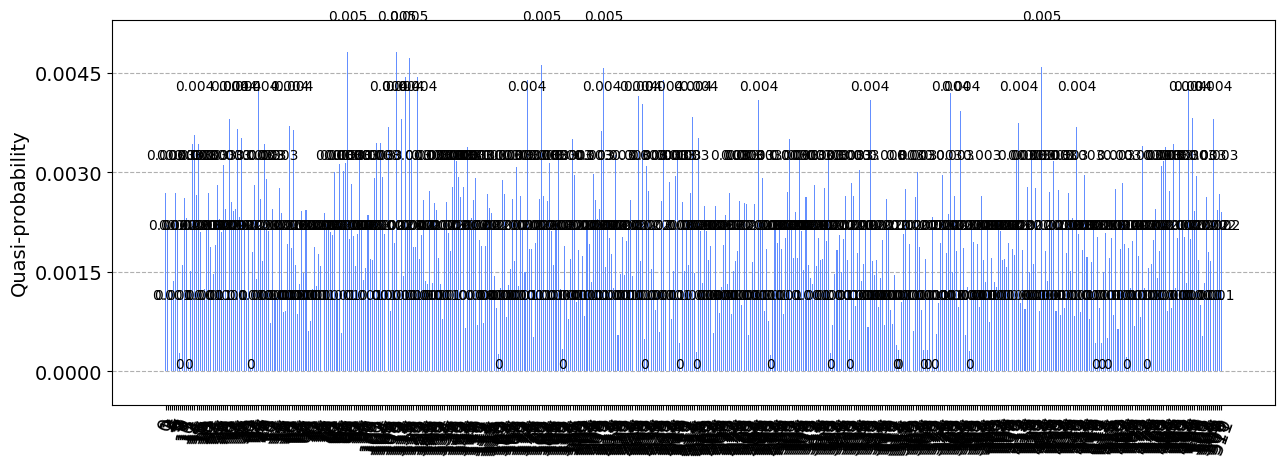

In [135]:
from qiskit.visualization import plot_distribution
plot_distribution(samp_dist, figsize=(15, 5))